In [91]:
from generate_lib import *
from types import NoneType
import matplotlib.transforms as trs

In [26]:
SHOW_PLOTS = True
SAVE_PLOTS = True
GENERATE_DATA = False
SAVE_DATA = False
USE_CSV = True

In [27]:
ALIGNED = 0
RANDOM = 1

avgs = dict()
time = list()

def get_prob_avgs(filenames, clean = True):
    assert type(filenames) == list

    MAX_PLANETS = 9

    probs = dict()
    avgs = dict()

    probs[ALIGNED] = dict()
    probs[RANDOM] = dict()
    avgs[ALIGNED] = dict()
    avgs[RANDOM] = dict()
    
    time = np.array([])

    suffix = '_randomO'

    failed_systems = []
    sucessful_systems = []

    for filename in filenames:
        filepath = os.path.join(path, filename)

        (header, data) = csv_2_data(filepath)

        time_col = header.index('Time')

        end_time = float(data[time_col][-1])

        if end_time < 1e6:
            failed_systems.append(filename)

            continue
        else:
            sucessful_systems.append(filename)

        if len(time) == 0:
            time = data[time_col].astype(float)

        for n in range(MAX_PLANETS + 1):
            head = n_planet_prob(n)
            
            if head not in header:
                continue

            key = [ALIGNED, RANDOM][(suffix in filename)]
            col = header.index(head)

            prob = (clean_data(data[col].astype(float), scan = False) if clean else data[col].astype(float))

            if head not in probs[key]:
                probs[key][head] = [prob]
            else:
                probs[key][head].append(prob)

    for key in probs:
        for head in probs[key]:
            avgs[key][head] = list()

            # Transpose the matrix.
            probs[key][head] = np.array(probs[key][head]).T

            for idx in range(len(probs[key][head])):
                avgs[key][head].append(np.nanmean(probs[key][head][idx]))

    num_failed = len(failed_systems)
    num_succeeded = len(sucessful_systems)
    pct_failed = (num_failed / (num_failed + num_succeeded)) * 100.0

    output = '''SYSTEMS:
    # failed: {failed}
    # succeeded: {succ}
    % failed: {pct}%
    '''.format(failed = num_failed, succ = num_succeeded, pct = pct_failed)

    print(output)

    return (time, avgs)

In [28]:
def save_data(savename, heads):
    if '.csv' not in savename:
        savename += '.csv'

    savepath = os.path.join(os.pardir, 'results', 'avg_prob_values', savename)

    data = avgs[ALIGNED]
    rdata = avgs[RANDOM]

    output = [time]

    header = 'Time,'

    for head in heads:
        if head in data:
            header += ',' + head + ' (Aligned Omega)'
            output.append(data[head])
        
        if head in rdata:
            header += ',' + head + ' (Random Omega)'
            output.append(rdata[head])

    header += '\n'
    output = list(np.array(output).T)

    with open(savepath, 'w', encoding = 'utf-8') as file:
        file.write(header)

        for idx in range(len(output)):
            line = ''
            
            for idx2 in range(len(output[idx])):
                line += ',' + str(output[idx][idx2])

            line += '\n'

            file.write(line)

In [29]:
def generate_data(systems):
    (time, avgs) = get_prob_avgs(systems)

    heads = sorted(list(set(list(avgs[RANDOM].keys()) + list(avgs[ALIGNED].keys()))))

    if SAVE_DATA:
        save_data('avg_prob_values.csv', heads)
    
    return (time, avgs)

In [30]:
if GENERATE_DATA:
    systems = data_files
    unstable_systems = ['sysSim_88.csv']

    for sys in unstable_systems:
        if sys in systems:
            systems.remove(sys)

    (time, avgs) = generate_data(systems)

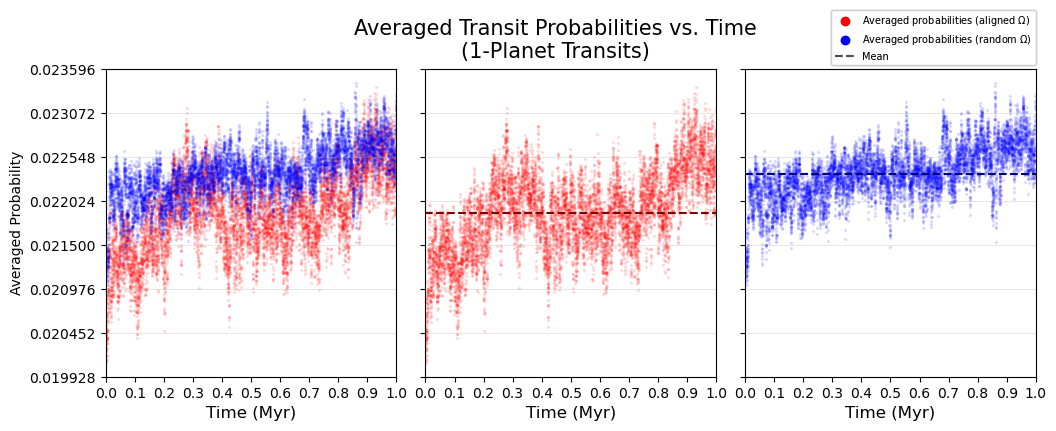

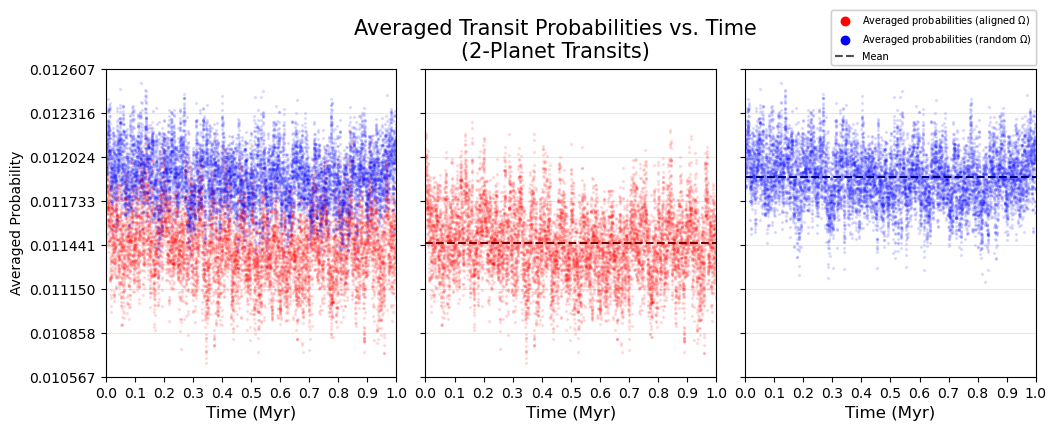

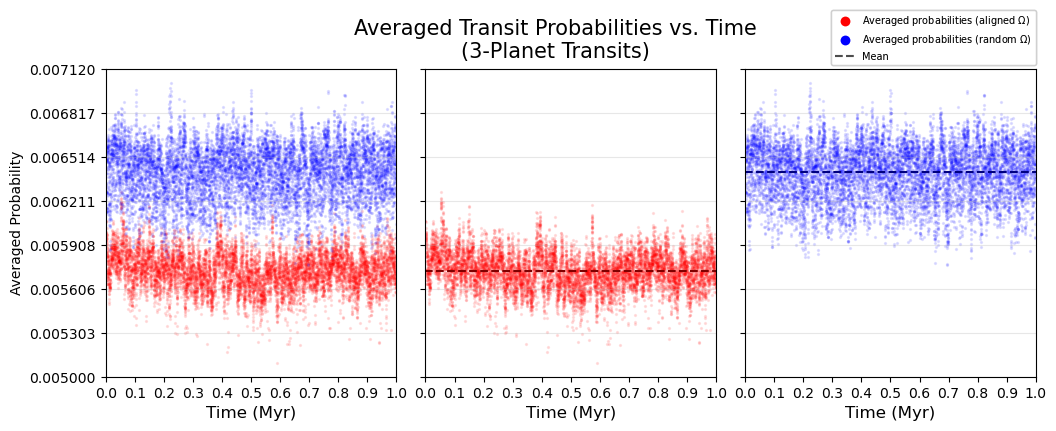

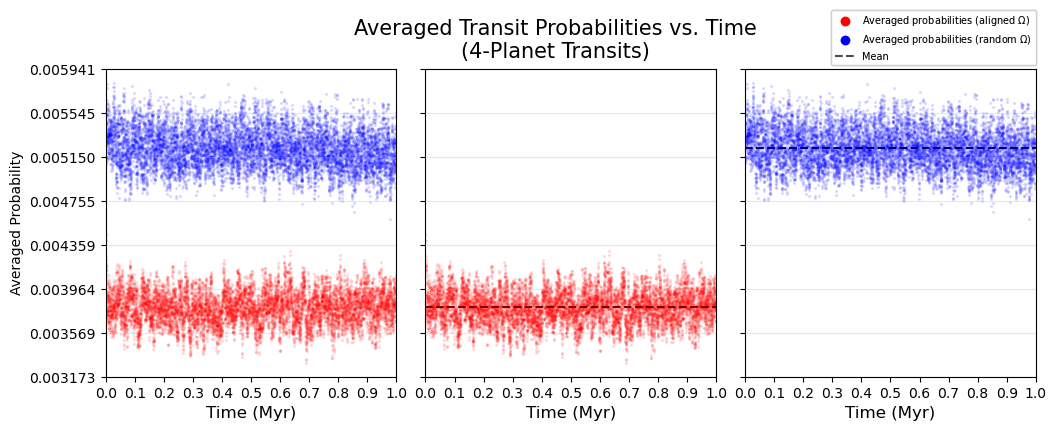

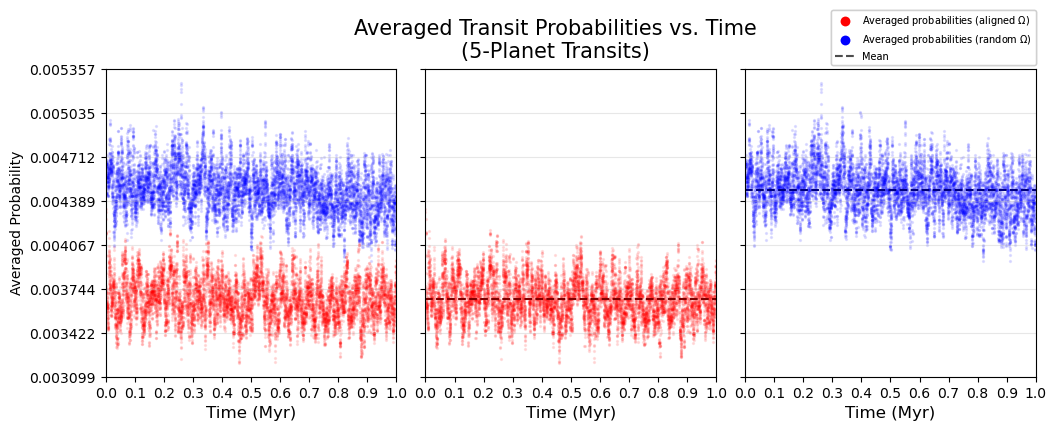

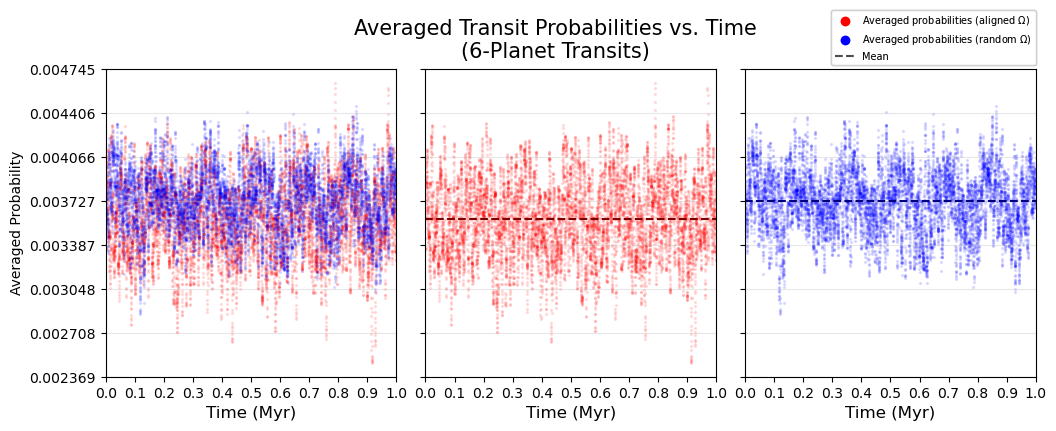

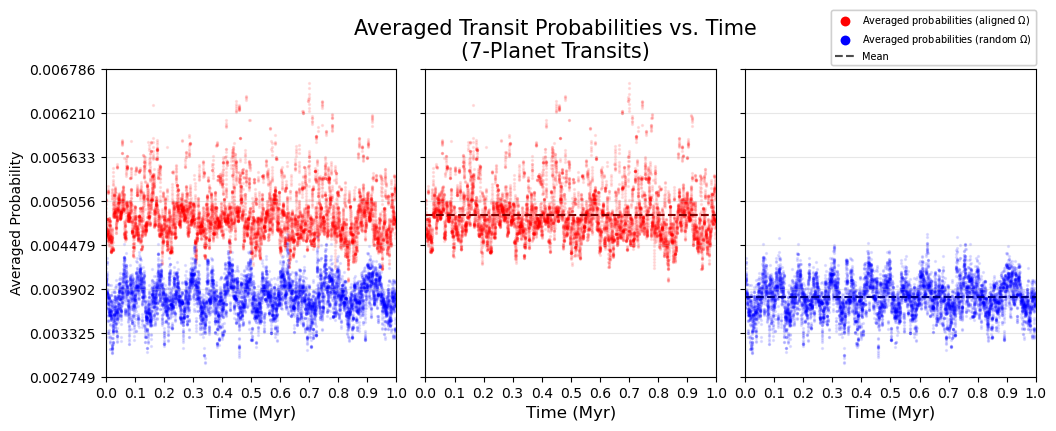

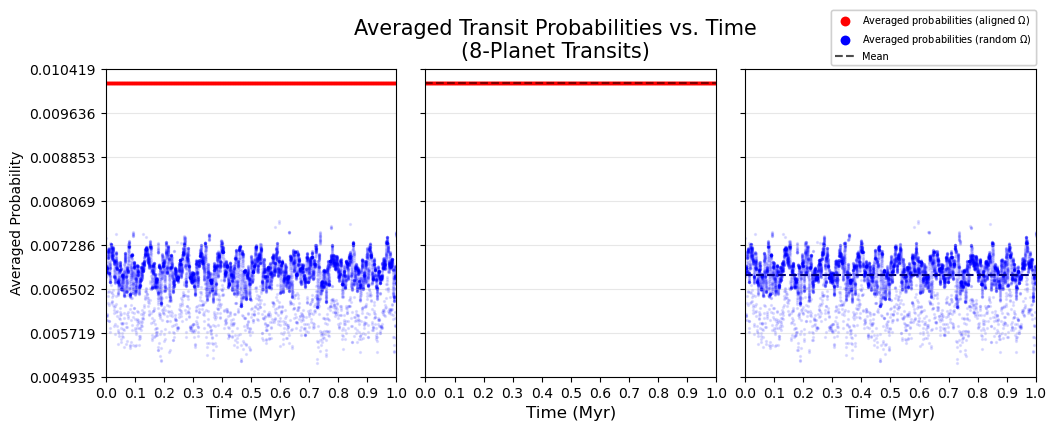

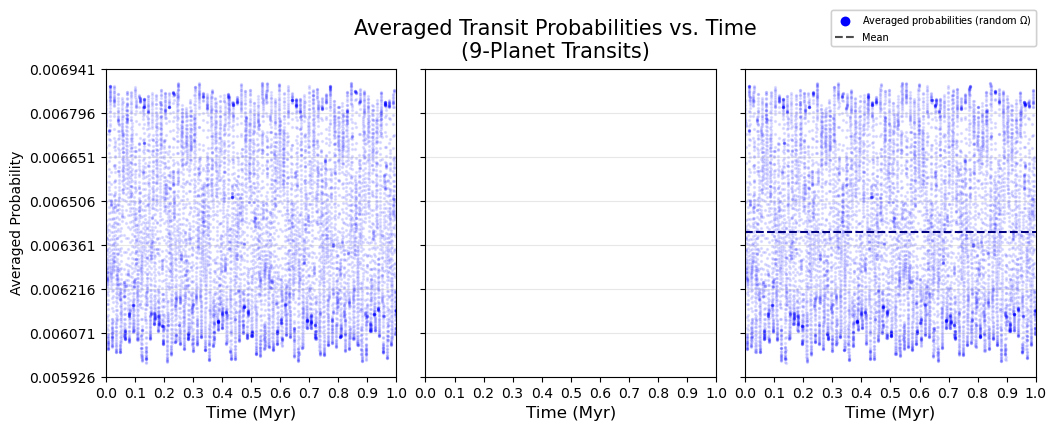

In [94]:
if USE_CSV:
    p = os.path.join(os.pardir, 'results', 'avg_prob_values', 'avg_prob_values.csv')
    (header, data) = csv_2_data(p)

    if len(avgs) == 0:
        avgs[RANDOM] = dict()
        avgs[ALIGNED] = dict()

    for head in header:
        planet_head = head.split('(')[0].strip()
        col = header.index(head)
        col_data = data[col].astype(float)

        if 'Time' in head:
            time = col_data
        elif '(Aligned Omega)' in head:
            avgs[ALIGNED][planet_head] = col_data
        elif '(Random Omega)' in head:
            avgs[RANDOM][planet_head] = col_data

        assert len(time) == len(data[col])

heads = sorted(list(set(list(avgs[RANDOM].keys()) + list(avgs[ALIGNED].keys()))))

for head in heads:
    (fig, axes) = plt.subplots(1, 3, sharey = True)
    fig.set_size_inches(12, 4)

    (x, y) = (time, avgs[ALIGNED][head]) if head in avgs[ALIGNED] else (None, None)
    (rx, ry) = (time, avgs[RANDOM][head]) if head in avgs[RANDOM] else (None, None)

    assert time[0] == 0.0 and time[-1] == 1e6

    # Hard coded, but assertion should catch any cases where this is false.
    xmin = 0.0
    xmax = 1e6

    plt.subplot(1, 3, 1)

    if type(y) != NoneType:
        plt.scatter(x, y, s = 2, alpha = 0.1, color = 'red')
        plt.scatter([], [], color = 'red', label = 'Averaged probabilities (aligned $\Omega$)')
    
    if type(ry) != NoneType:
        plt.scatter(rx, ry, s = 2, alpha = 0.1, color = 'blue')
        plt.scatter([], [], color = 'blue', label = 'Averaged probabilities (random $\Omega$)')

    plt.subplot(1, 3, 2)

    if type(y) != NoneType:
        plt.scatter(x, y, s = 2, alpha = 0.1, color = 'red')

        mean = np.nanmean(y)
        plt.hlines(mean, xmin, xmax, color = (0.5, 0, 0.0), linestyles = 'dashed')

    plt.subplot(1, 3, 3)
    
    if type(ry) != NoneType:
        plt.scatter(rx, ry, s = 2, alpha = 0.1, color = 'blue')

        mean = np.nanmean(ry)
        plt.hlines(mean, xmin, xmax, color = (0, 0, 0.5), linestyle = 'dashed')

    plt.plot([], [], color = (0.3, 0.3, 0.3), label = 'Mean', linestyle = 'dashed')

    for col in range(len(axes)):
        ax = axes[col]

        ax.grid(True, axis = 'y', alpha = 0.3)

        if col == 0:
            ax.set_ylabel('Averaged Probability', fontsize = 10)

        ax.set_xlabel('Time (Myr)', fontsize = 12)
        ax.xaxis.set_major_locator(tck.LinearLocator(11))
        ax.xaxis.set_major_formatter(tck.FuncFormatter(lambda x, pos: '%.1f' % (x/1e6)))
        ax.yaxis.set_major_locator(tck.LinearLocator(8))

        ax.set_xlim(xmin, xmax)    

        title = 'Averaged Transit Probabilities vs. Time\n({planets} Transits)'.format(planets=head.replace('s', '').replace(' ', '-'))

        fig.suptitle(title, y = 1.005, fontsize = 15)

        fig.legend(bbox_to_anchor = (0.7255, 1.04), loc = 'upper left', fontsize = 7)
        plt.subplots_adjust(wspace = 0.1, hspace = 0)

    if SAVE_PLOTS:
        save_path = os.path.join(os.pardir, 'results', 'avg_prob_values', 'avg_prob_{n}_planets'.format(n = head.split(' ')[0]))
        fig.savefig(save_path, dpi = 400, bbox_inches = 'tight')

    if SHOW_PLOTS:
        plt.show()